# Markov Chains
A Markov chain model assumes that the change between match states does not depend on what has happened earlier, only on the current state. If the attacking team has the ball in midfield, the probability of it going into the box is the same, irrespective of whether the team has carried out a long sequence of passes, or if the ball has just arrived from a punt. This assumption oversimplifies aspects of football tactics, but it is a reasonable starting point.  Generally the window associated with ball movement is limited to about 10sec.

In this section expected threat will be determined in terms of a Markov chain.

In [1]:
import numpy as np

### Setting up the matrix
Set up the pass matrix A and the goal vector g.  The two arrays will represent the probability of the ball moving into anther area of the field (matrix A) and the likelihood of a goal from the associated position (vector g).  This will be used to solve for xT.

Table of probabilites:

|from/to|Mid|Box|Wing|Goal|
|---|---|---|---|---|
|Mid|25%|20%|10%|5%|
|Box|10%|25%|20%|15%|
|Wing|10%|10%|25%|5%|


In [2]:
# Pass matrix
A = np.matrix([[0.25, 0.20, 0.1], [0.1, 0.25, 0.2],[0.1, 0.1, 0.25]])
A

matrix([[0.25, 0.2 , 0.1 ],
        [0.1 , 0.25, 0.2 ],
        [0.1 , 0.1 , 0.25]])

In [3]:
# Goal vector
g = np.transpose(np.matrix([0.05, 0.15, 0.05]))
g

matrix([[0.05],
        [0.15],
        [0.05]])

### Linear algebra method
Solve the linear algerbra formula $(I-A)xT = g$ for xT.

In [4]:
xT1 = np.linalg.solve(np.identity(3) - A,g)

print('Expected Threat')
print('Central, Box, Wing')
print(np.transpose(xT1))

Expected Threat
Central, Box, Wing
[[0.14991763 0.25205931 0.12026359]]


### Iterative method
Iterate xT’ = A xT + g to update through each move of the ball.

In [5]:
xT2=np.zeros((3,1))
for t in range(10):
#    print(np.matmul(A,xT2) + g)
   xT2 = np.matmul(A,xT2) + g

In [6]:
print('Expected Threat')
print('Central, Box, Wing')
print(np.transpose(xT2))

Expected Threat
Central, Box, Wing
[[0.14966911 0.25182476 0.12007973]]


### Simulation method
Simulate num_sim possessions, starting from each of the three areas.  The simulation uses a random float generation to evaluate the 10 simulations and determine if a goal was scored.  The expected threat is then recalculated based on the number of goals ratio over the number of simulations conducted.  This will vary with each run through the code.  I provides an indication of how this might be evaluated manually.

Originally this was run at 10 simulations and it is quite vairable.  As you increase the simulations to 100, the values begin to coalesce at the same numbers in the prior solutions.

In [7]:
num_sims=100
xT3=np.zeros(3)

description = {0: 'Central', 1: 'Wing', 2: 'Box' }

for i in range(3):
    num_goals = 0

    print('---------------')
    print('Start from ' + description[i] )
    print('---------------')

    for n in range(num_sims):

        ballinplay=True
        #Initial state is i
        s = i
        describe_possession=''

        while ballinplay:
            r=np.random.rand()

            # Make commentary text
            describe_possession = describe_possession + ' - ' + description[s]


            #Cumulative sum of in play probabilities
            c_sum=np.cumsum(A[s,:])
            new_s = np.sum(r>c_sum)
            if new_s>2:
                #Ball is either goal or out of play
                ballinplay=False
                if r < g[s] + c_sum[0,2]:
                    #Its a goal!
                    num_goals = num_goals + 1
                    describe_possession = describe_possession + ' - Goal!'
                else:
                    describe_possession = describe_possession + ' - Out of play'
            s = new_s

        print(describe_possession)

    xT3[i] = num_goals/num_sims


print('\n\n---------------')
print('Expected Threat')
print('Central, Box, Wing')
print(xT3)

---------------
Start from Central
---------------
 - Central - Wing - Central - Central - Out of play
 - Central - Out of play
 - Central - Out of play
 - Central - Central - Central - Out of play
 - Central - Central - Out of play
 - Central - Out of play
 - Central - Box - Out of play
 - Central - Wing - Wing - Goal!
 - Central - Central - Goal!
 - Central - Central - Central - Out of play
 - Central - Wing - Out of play
 - Central - Box - Box - Out of play
 - Central - Goal!
 - Central - Out of play
 - Central - Box - Box - Box - Box - Box - Out of play
 - Central - Wing - Goal!
 - Central - Out of play
 - Central - Out of play
 - Central - Out of play
 - Central - Central - Out of play
 - Central - Central - Out of play
 - Central - Box - Wing - Out of play
 - Central - Out of play
 - Central - Out of play
 - Central - Out of play
 - Central - Out of play
 - Central - Central - Goal!
 - Central - Out of play
 - Central - Wing - Out of play
 - Central - Central - Wing - Out of play

# Calculated Expected Threat xT
Using a position based approach, expected threat, xT, will be determined for locations on the field.  This process was introduced to the world by Karun Singh in a blog post in 2018 [xT](https://karun.in/blog/expected-threat.html).  It was an extension of the work introduced by Sarah Rudd's Markov Model.

### Imports
Required imports, commenting out anything that has already been loaded in the notebook.

In [8]:
# importing necessary libraries
import pandas as pd
# import numpy as np # already loaded
import json
# plotting
import matplotlib.pyplot as plt
# opening data
import os
import pathlib
import warnings
# used for plots
from mplsoccer import Pitch
from scipy.stats import binned_statistic_2d

pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

### Opening data
Implement the Expected Threat model in the same way described by Karun Singh. First, extract the required event data to begin the assignment of values and iterate to a solution.  In this example, Wyscout data will be leveraged. 

In [9]:
#load data - store it in train dataframe
df = pd.DataFrame()
with open('./data/events_England.json') as f:
    data = json.load(f)
    df = pd.DataFrame(data)

In [10]:
df.head(3)

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173


### Actions moving the ball
Calculating Expected Threat can only occur for actions that move the ball. 
1. First filter passes from the database. 
2. Then remove passes that ended out of the pitch. 
3. To make the calculations easier create new columns with coordinates, one for each coordinate. 
4. Then, plot the location of actions moving the ball on 2D histogram. 

Note that dribbling is also an action that moves the ball. However, Wyscout does not store them in the v2 version that we are using in the course and not all ground attacking duels are dribblings. **In the end we store number of actions in each bin in a move_count array to calculate later move probability.**

In [11]:
next_event = df.shift(-1, fill_value=0)
move_df = (df
      .assign(nextEvent = next_event["subEventName"],
              kickedOut = lambda df: np.where(df.nextEvent == "Ball out of the field",1,0))
      .loc[lambda df: df.subEventName.isin(['Simple pass', 'High pass', 'Head pass', 'Smart pass', 'Cross'])]
      .query('kickedOut == 0')
      .assign(x = lambda df: df.positions.apply(lambda cell: (cell[0]['x']) * 105/100),
              y = lambda df: df.positions.apply(lambda cell: (100 - cell[0]['y']) * 68/100),
              end_x = lambda df: df.positions.apply(lambda cell: (cell[1]['x']) * 105/100),
              end_y = lambda df: df.positions.apply(lambda cell: (100 - cell[1]['y']) * 68/100))
      .query('(end_x != 0 and end_y != 68)' and '(end_x != 105 and end_y != 0)')
          )

move_df.head(3)

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,nextEvent,kickedOut,x,y,end_x,end_y
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171,High pass,0,51.45,34.68,32.55,14.96
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172,Head pass,0,32.55,14.96,53.55,17.00
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173,Head pass,0,53.55,17.00,36.75,19.72


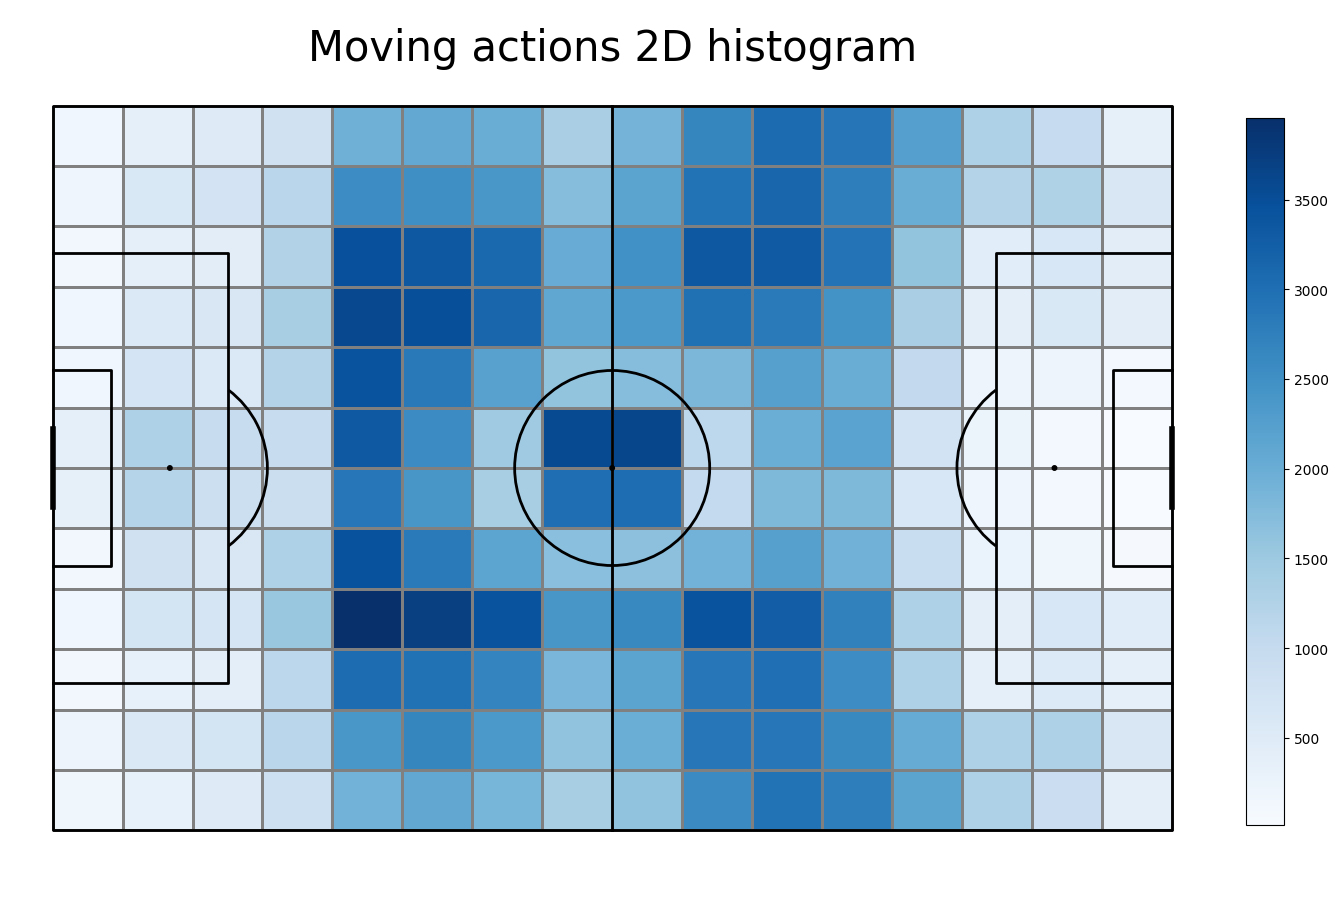

In [12]:
#create 2D histogram of these
pitch = Pitch(line_color='black',pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
move = pitch.bin_statistic(move_df.x, move_df.y, statistic='count', bins=(16, 12), normalize=False)

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
pcm  = pitch.heatmap(move, cmap='Blues', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Moving actions 2D histogram', fontsize = 30)
plt.show()
#get the array
move_count = move["statistic"]

### Shots
To calculate the Expected Threat requires shots. 
1. Filter them from the database. 
2. Create new columns with the coordinates and plot their location. 
3. Store the number of shot occurences in each bin in a 2D array as well.

In [13]:
#get shot df
shot_df = (df.loc[df.subEventName == "Shot"]
           .assign(x = lambda df_:df_.positions.apply(lambda cell: (cell[0]['x']) * 105/100),
                   y = lambda df_:df_.positions.apply(lambda cell: (100 - cell[0]['y']) * 68/100))
          )

shot_df.head(3)

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,x,y
46,10,Shot,"[{'id': 101}, {'id': 402}, {'id': 201}, {'id':...",25413,"[{'y': 41, 'x': 88}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,94.595788,100,177959212,92.40,40.12
62,10,Shot,"[{'id': 401}, {'id': 201}, {'id': 1211}, {'id'...",26150,"[{'y': 52, 'x': 85}, {'y': 100, 'x': 100}]",2499719,Shot,1631,1H,179.854785,100,177959247,89.25,32.64
91,10,Shot,"[{'id': 101}, {'id': 403}, {'id': 201}, {'id':...",14763,"[{'y': 52, 'x': 96}, {'y': 100, 'x': 100}]",2499719,Shot,1631,1H,254.745027,100,177959280,100.80,32.64


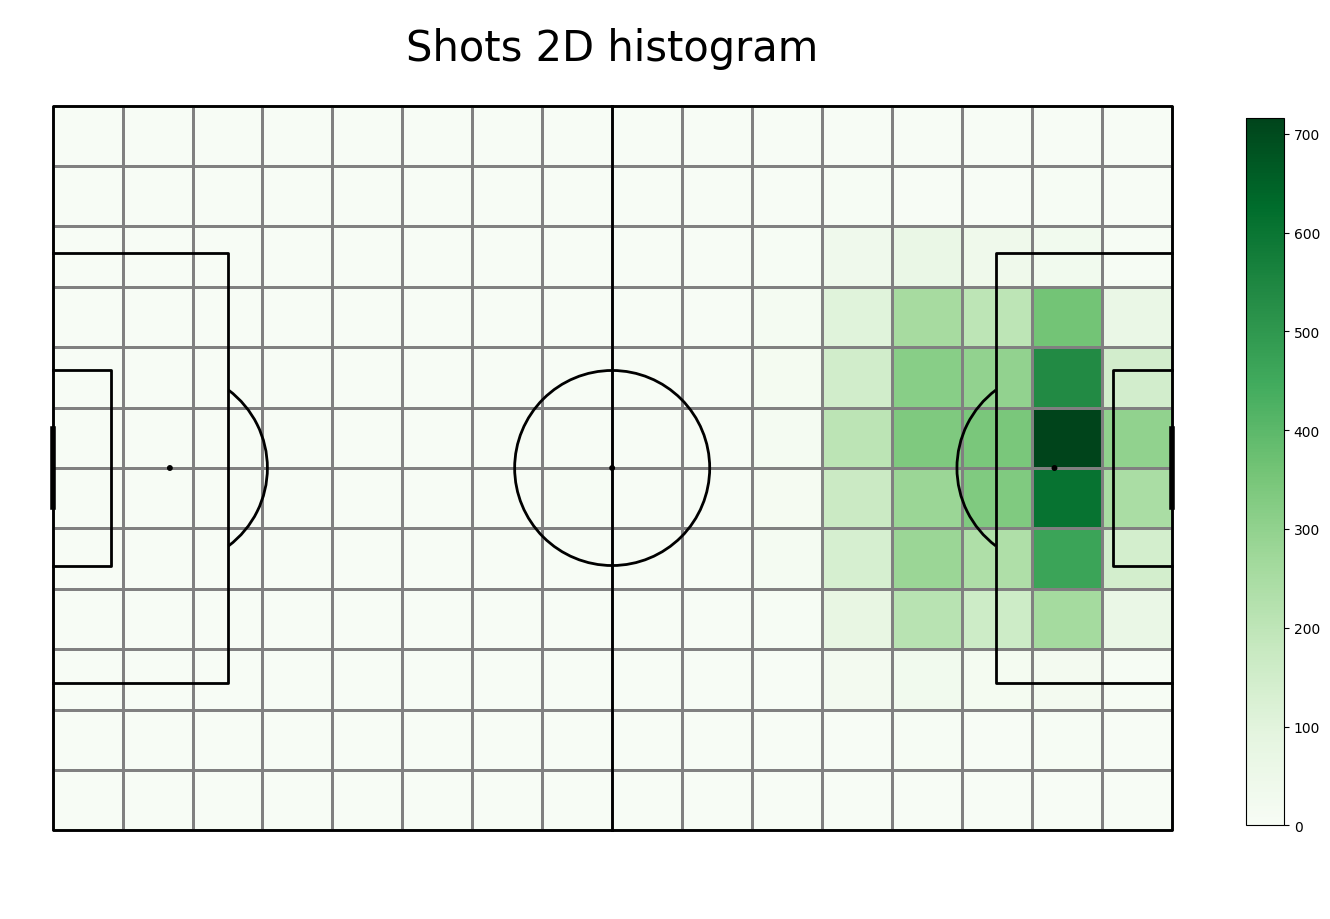

In [14]:
#create 2D histogram of these
shot = pitch.bin_statistic(shot_df.x, shot_df.y, statistic='count', bins=(16, 12), normalize=False)

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
pcm  = pitch.heatmap(shot, cmap='Greens', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Shots 2D histogram', fontsize = 30)
plt.show()

shot_count = shot["statistic"]

### Goals
To calculate the Expected Threat requires goals. 
1. filter them from the shots dataframe. 
2. Store the number of goal occurences in each bin in 2D array as well.

In [15]:
#get goal df
goal_df  = shot_df.loc[lambda df_:df_.apply(lambda x: {'id':101} in x.tags, axis = 1)]
goal_df.head(3)

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,x,y
46,10,Shot,"[{'id': 101}, {'id': 402}, {'id': 201}, {'id':...",25413,"[{'y': 41, 'x': 88}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,94.595788,100,177959212,92.4,40.12
91,10,Shot,"[{'id': 101}, {'id': 403}, {'id': 201}, {'id':...",14763,"[{'y': 52, 'x': 96}, {'y': 100, 'x': 100}]",2499719,Shot,1631,1H,254.745027,100,177959280,100.8,32.64
554,10,Shot,"[{'id': 101}, {'id': 402}, {'id': 201}, {'id':...",12829,"[{'y': 54, 'x': 94}, {'y': 100, 'x': 100}]",2499719,Shot,1631,1H,1710.855093,100,177959759,98.7,31.28


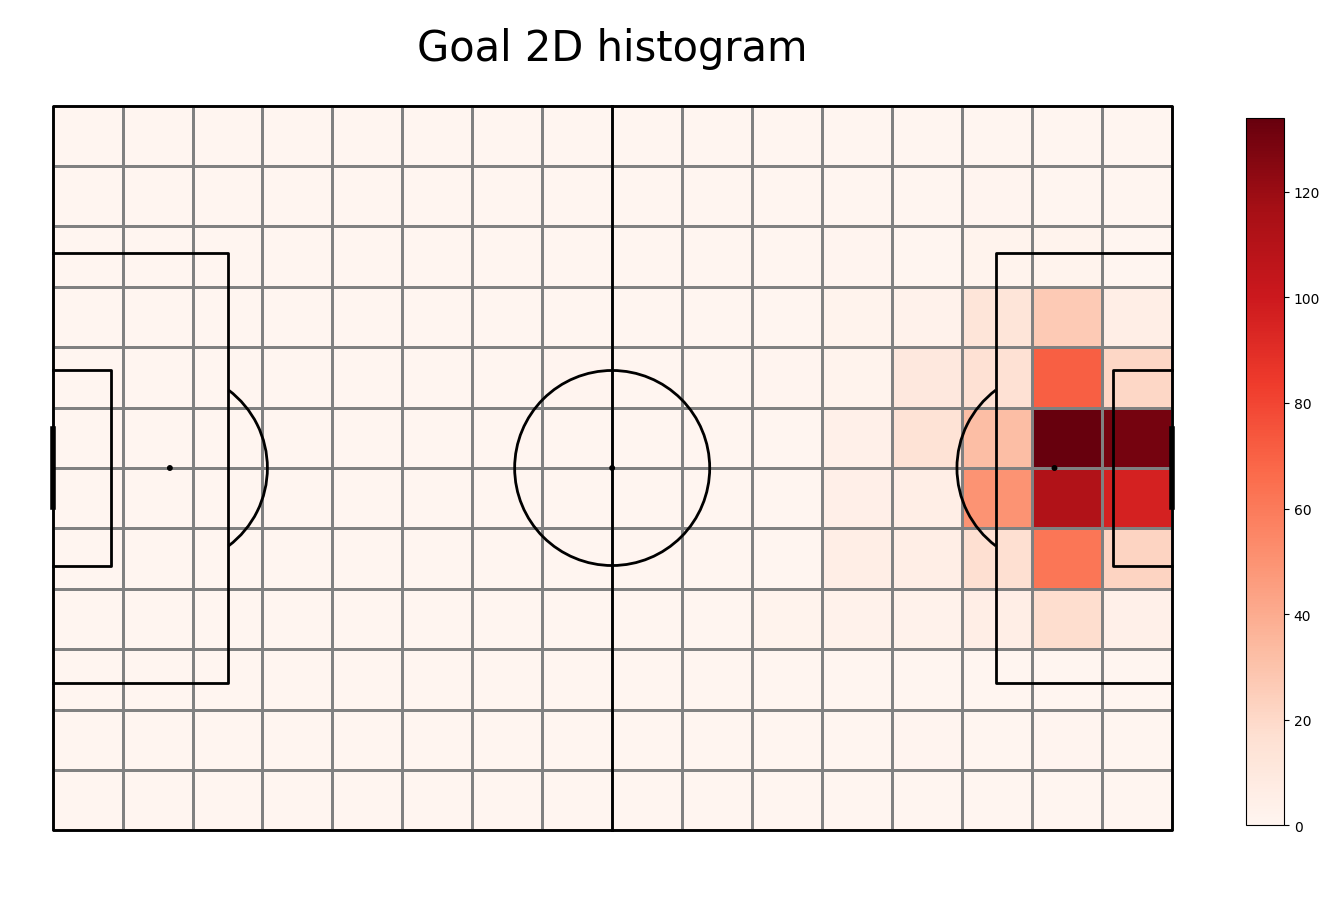

In [16]:
goal = pitch.bin_statistic(goal_df.x, goal_df.y, statistic='count', bins=(16, 12), normalize=False)
goal_count = goal["statistic"]

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
pcm  = pitch.heatmap(goal, cmap='Reds', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Goal 2D histogram', fontsize = 30)
plt.show()

### Move probability
Next calculate the probability of each moving action. To do so, divide the move count number in each bin by the sum of moving actions and shots in that bin. Then, plot it.

In [17]:
move_probability = move_count/(move_count+shot_count)

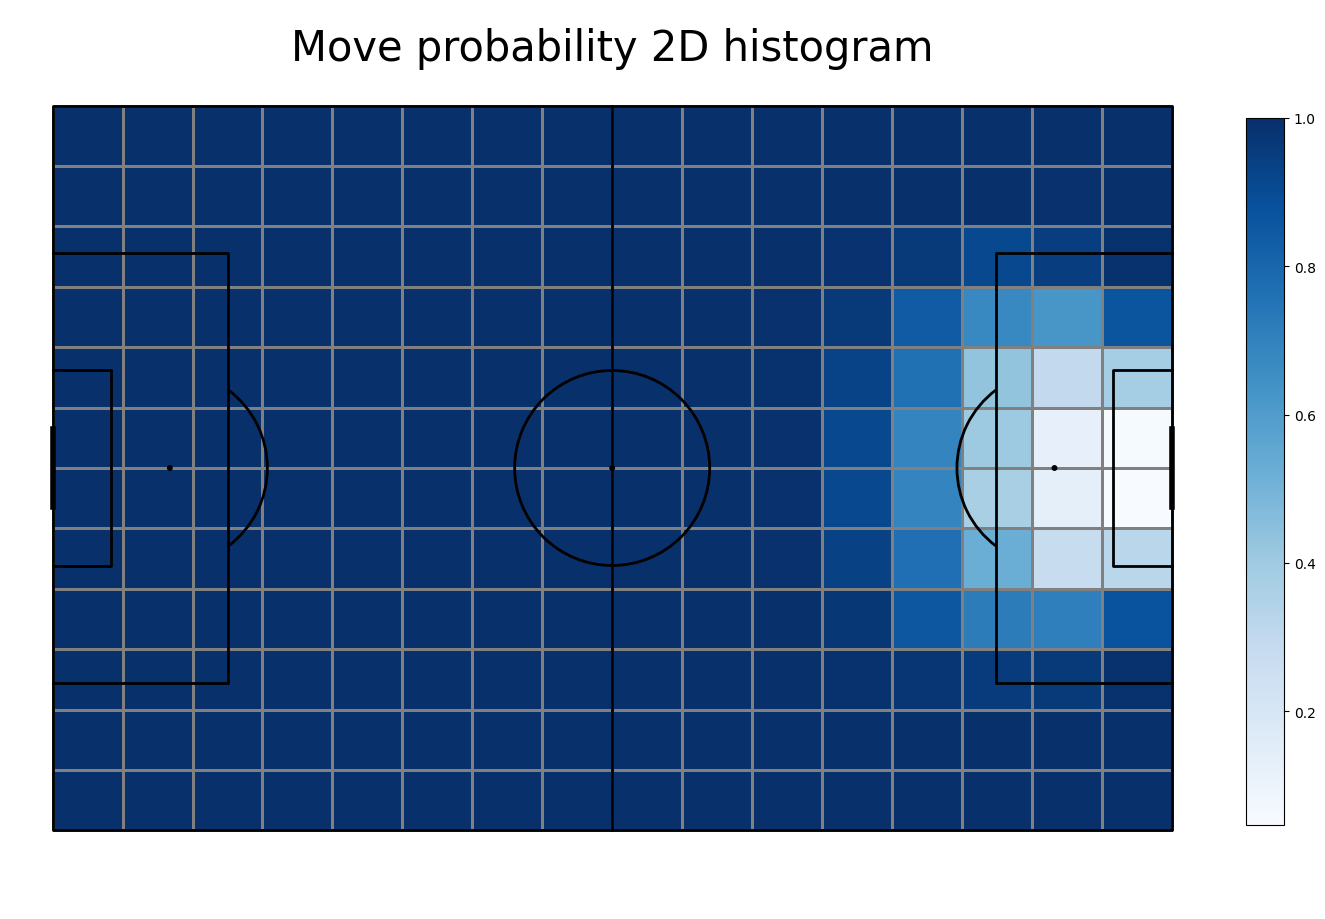

In [18]:
#plotting it
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
move["statistic"] = move_probability
pcm  = pitch.heatmap(move, cmap='Blues', edgecolor='grey', ax=ax['pitch'], label=move)
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Move probability 2D histogram', fontsize = 30)
plt.show()

### Shot probability
Calculate the probability of a shot in each area. 
1. Divide its number in each bin by the sum of moving actions and shots in that bin. 
2. Then plot it.



In [19]:
shot_probability = shot_count/(move_count+shot_count)

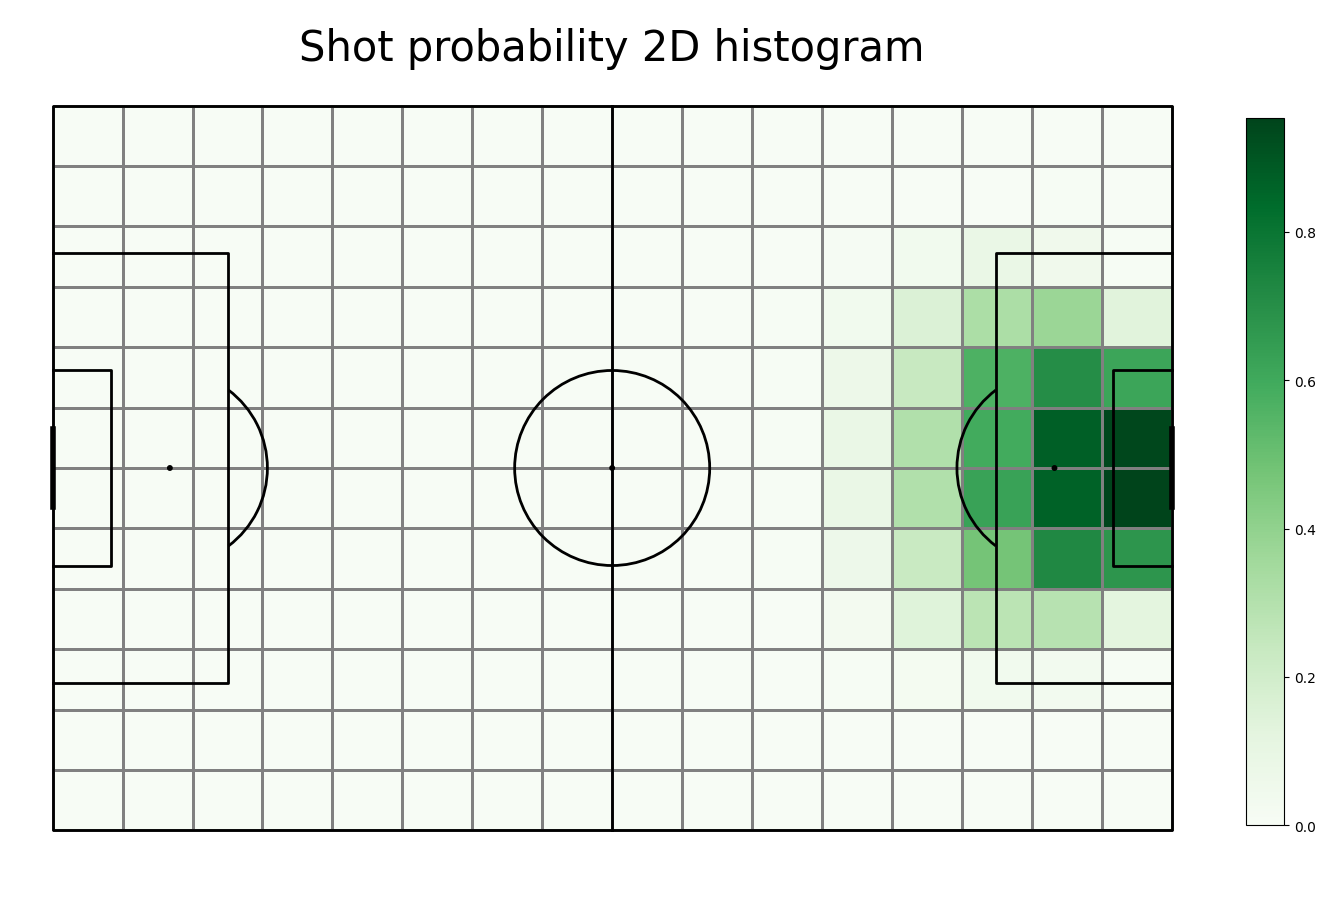

In [20]:
#plotting it
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
shot["statistic"] = shot_probability
pcm  = pitch.heatmap(shot, cmap='Greens', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Shot probability 2D histogram', fontsize = 30)
plt.show()

### Goal probability
Determine the goal probability. It’s calculated here in a rather naive way - number of goals in an area divided by number of shots in the same area. This is a simplified expected goals model.

In [21]:
goal_probability = goal_count/shot_count
goal_probability[np.isnan(goal_probability)] = 0

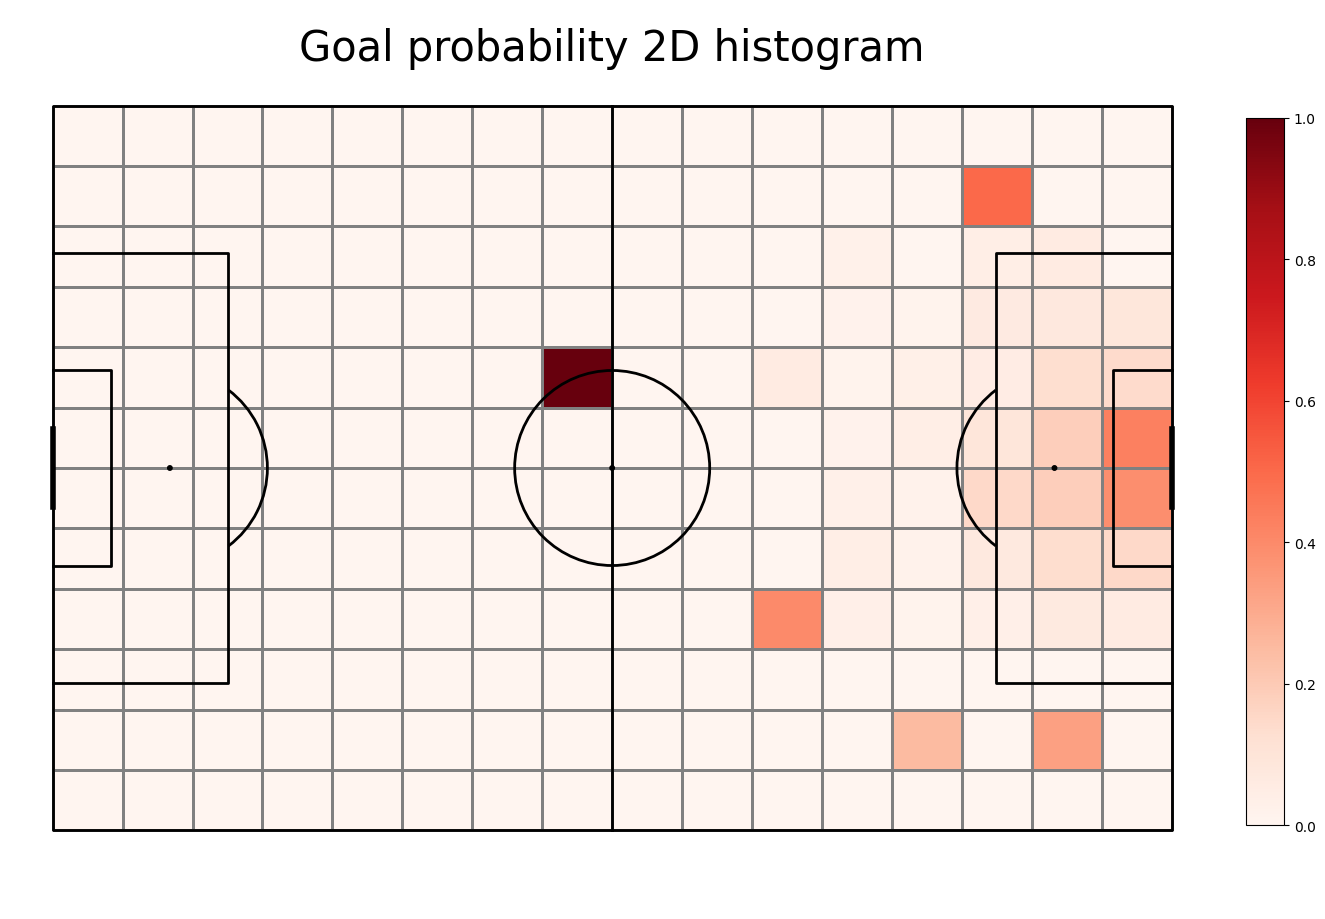

In [22]:
#plotting it
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
goal["statistic"] = goal_probability
pcm  = pitch.heatmap(goal, cmap='Reds', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Goal probability 2D histogram', fontsize = 30)
plt.show()

### Transition matirices
The transition matrix is required for each of 192 sectors. This is a matrix of probabilities for going from one zone to another given that the ball was moved. 
1. First, create another column in the move_df with the bin on the histogram that the event started and ended in.
2. Then, group the data by starting sector and count starts from each of them. 
3. For each of the sectors, calculate the probability of transfering the ball from the current sector to all 192 sectors on the pitch.  This is the division of events that went to the end sector for all events that started in the starting sector. 
4. Vizualize the transition matrix for the sector in the bottom left corner of the pitch.

#### Refactoring
The previous process of using apply was extremely slow and took nearly 40s to finish for the dataframe at 300k rows.  After some evaluation, using the entier dataframe and leveraging the xip function, the time is optimized significantly to improve the analysis.  The old appy functions are left for reference and commented out followed by the refactored code below.

In [23]:
# move start index - using the same function as mplsoccer, it should work
# move_df["start_sector"] = move_df.apply(lambda row: tuple([i[0] for i in binned_statistic_2d(np.ravel(row.x), np.ravel(row.y),
#                                                                values = "None", statistic="count",
#                                                                bins=(16, 12), range=[[0, 105], [0, 68]],
#                                                                expand_binnumbers=True)[3]]), axis = 1)

In [24]:
# move end index - again using the same function as mplsoccer library
# move_df["end_sector"] = move_df.apply(lambda row: tuple([i[0] for i in binned_statistic_2d(np.ravel(row.end_x), np.ravel(row.end_y),
#                                                                values = "None", statistic="count",
#                                                                bins=(16, 12), range=[[0, 105], [0, 68]],
#                                                                expand_binnumbers=True)[3]]), axis = 1)

In [25]:
# this is the calculated binnumber from binned_statistic_2d, optimized in place of apply
move_df = (move_df
 .reset_index()
 .assign(start_sector = lambda df_: pd.Series(list(zip(*binned_statistic_2d(df_.x,df_.y, values=np.zeros(df_.x.size), 
                                                                         statistic="count", bins=(16, 12), 
                                                                         range=[[0, 105], [0, 68]],
                                                                         expand_binnumbers=True).binnumber))),
         end_sector = lambda df_: pd.Series(list(zip(*binned_statistic_2d(df_.end_x,df_.end_y, 
                                                                         values=np.zeros(df_.end_x.size), 
                                                                         statistic="count", bins=(16, 12), 
                                                                         range=[[0, 105], [0, 68]],
                                                                         expand_binnumbers=True).binnumber))))
)

In [26]:
move_df.iloc[:,-2:].head(3)

,start_sector,end_sector
0,"(8, 7)","(5, 3)"
1,"(5, 3)","(9, 4)"
2,"(9, 4)","(6, 4)"


#### Intermediate state
In this instance, the move_df is updated and a seperate frame is created for the intermediate state to group the starts by sector.  This will be leveraged to determine how many times each sector was found when the ball started in the sector defined by the groupby evaluation. 

In [27]:
# df with summed events from each index
df_count_starts = (move_df
                   .groupby(["start_sector"])
                   .eventId
                   .count()
                   .reset_index()
                   .rename(columns = {'eventId':'count_starts'}))

In [28]:
df_count_starts.head(3)

,start_sector,count_starts
0,"(1, 1)",168
1,"(1, 2)",224
2,"(1, 3)",134


In [29]:
transition_matrices = []
for i, row in df_count_starts.iterrows():
    start_sector = row['start_sector']
    count_starts = row['count_starts']
    #get all events that started in this sector
    df_cound_ends = (move_df
                     .loc[lambda df_:df_.start_sector == start_sector]
                     .groupby(["end_sector"])
                     .eventId
                     .count()
                     .reset_index()
                     .rename(columns = {'eventId':'count_ends'}))
    T_matrix = np.zeros((12, 16))
    for j, row2 in df_cound_ends.iterrows():
        end_sector = row2["end_sector"]
        value = row2["count_ends"]
        T_matrix[end_sector[1] - 1][end_sector[0] - 1] = value # position adjusted for zero index start
    T_matrix = T_matrix / count_starts # broadcasted division across the 16 elements
    transition_matrices.append(T_matrix)

#### Resultant Transition Matrix
The resultant matrix is 192 arrays, each containing 12 subarrays which are individually 16 elements long. This is demonstrated by the np.array().shape call below.  The individual value shown in the 0,0 matrix across the 16 entries is the frequency with which the ball achieved the position shown given the starting location.  Unfortunately, the starting position is not discernable from the resultant array, just the ending frequency given the number of starts.

In [30]:
np.array(transition_matrices).shape

(192, 12, 16)

In [31]:
transition_matrices[0][0]

array([0.08333333, 0.05952381, 0.0297619 , 0.04761905, 0.08333333,
       0.03571429, 0.0297619 , 0.00595238, 0.01190476, 0.00595238,
       0.00595238, 0.        , 0.        , 0.        , 0.        ,
       0.        ])

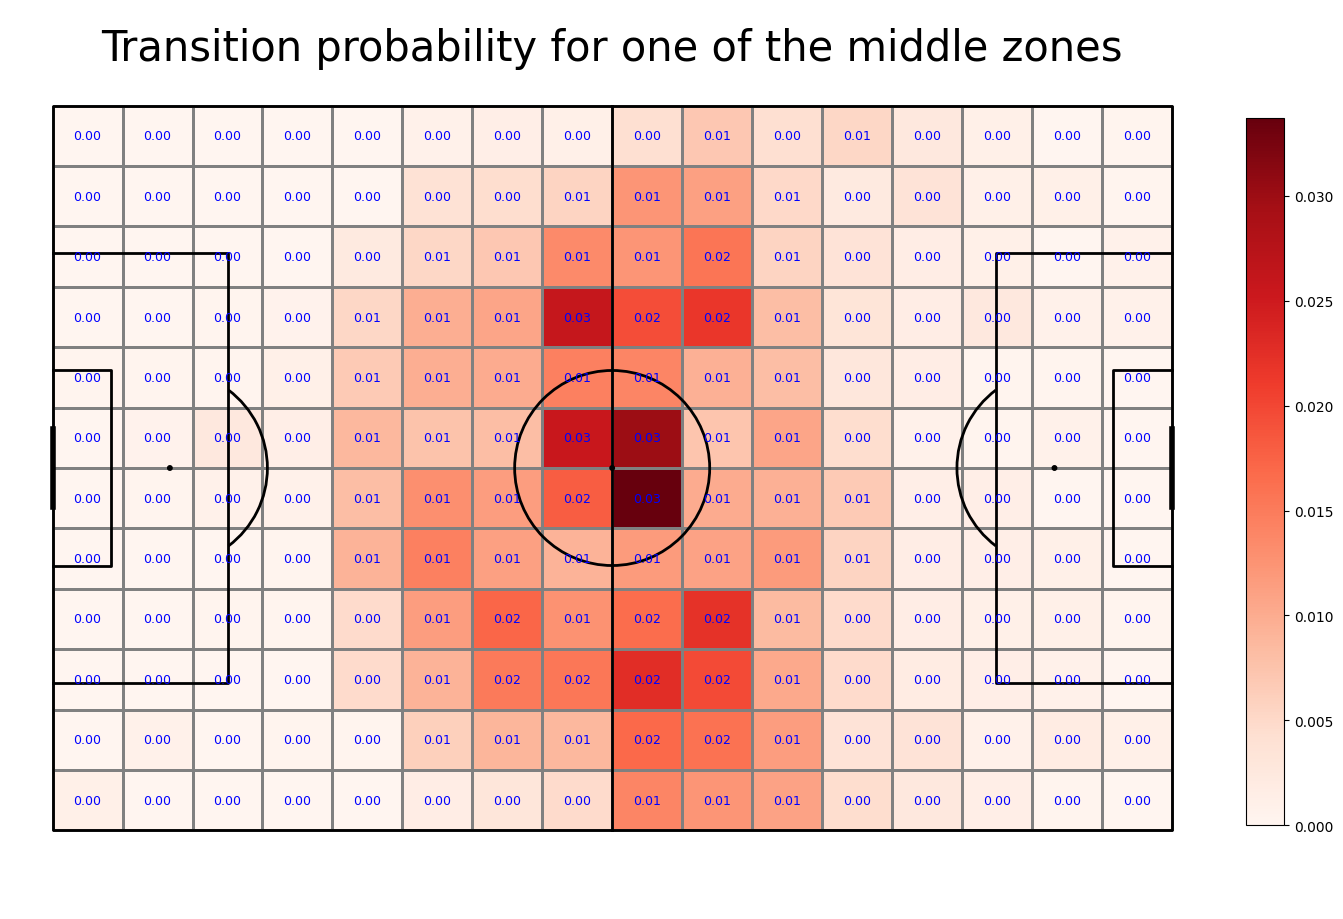

In [32]:
#let's plot it for the zone [1,1] - left down corner
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

#Change the index here to change the zone.
goal["statistic"] = transition_matrices[90]
pcm  = pitch.heatmap(goal, cmap='Reds', edgecolor='grey', ax=ax['pitch'])
labels = pitch.label_heatmap(goal, color='blue', fontsize=9,
                             ax=ax['pitch'], ha='center', va='center', str_format="{0:,.2f}", zorder = 3)
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Transition probability for one of the middle zones', fontsize = 30)
plt.show()

### Calculating Expected Threat matrix
Calculate the Expected Threat based upon the above work. 
1. Calculating scoring likelihood from position (probability of a shot)*(probability of a goal given a shot). This gives the probability of a goal being scored right away. This is the shoot_expected_payoff. 
2. Add this to the move_expected_payoff, which is what the payoff (probability of a goal) will be if the player passes the ball. It is this which is the xT

By iterating this process 6 times, the xT gradually converges to its final value.

In [33]:
transition_matrices_array = np.array(transition_matrices) # create np array for transitions
xT = np.zeros((12, 16)) # initialize zero matrix for xT


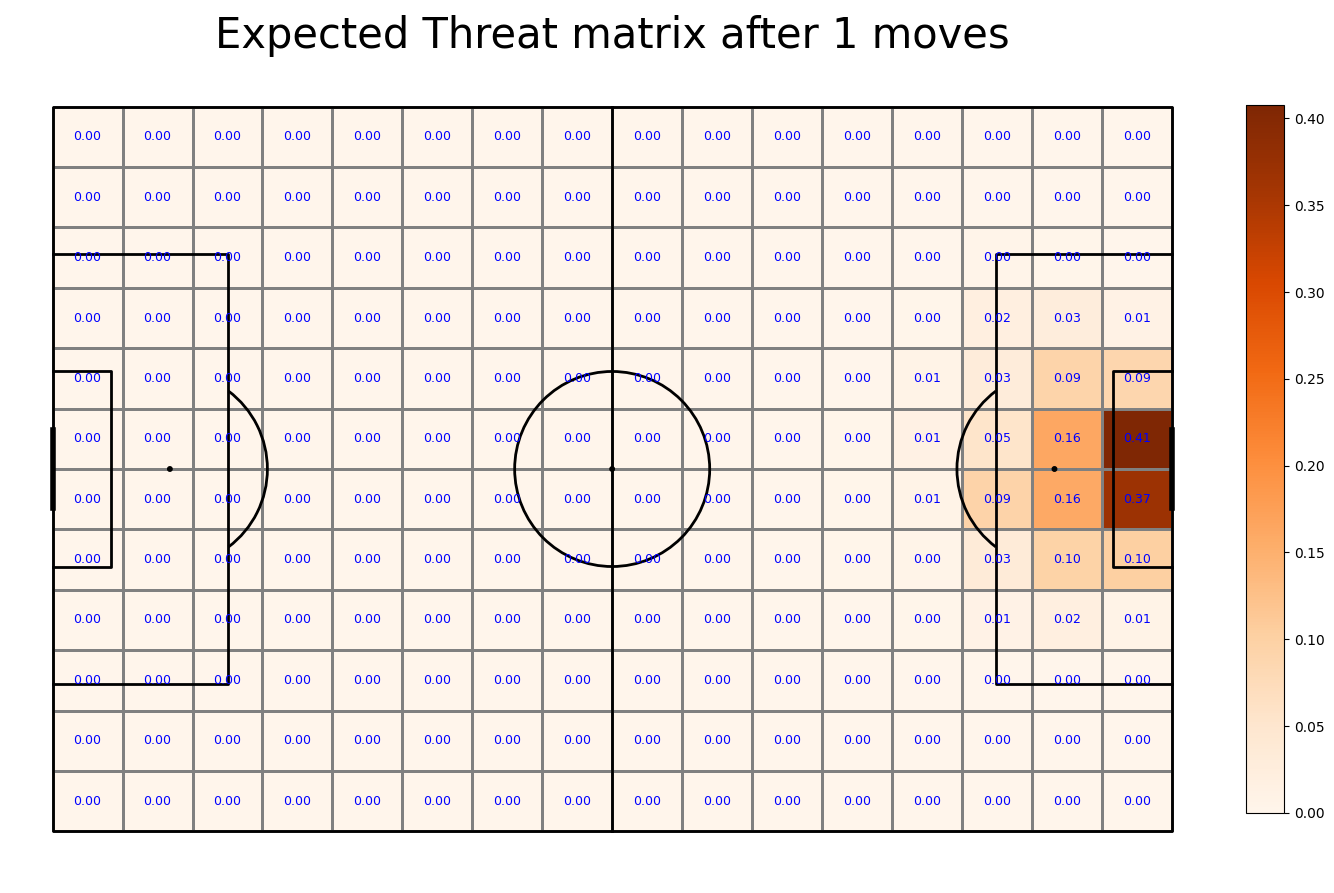

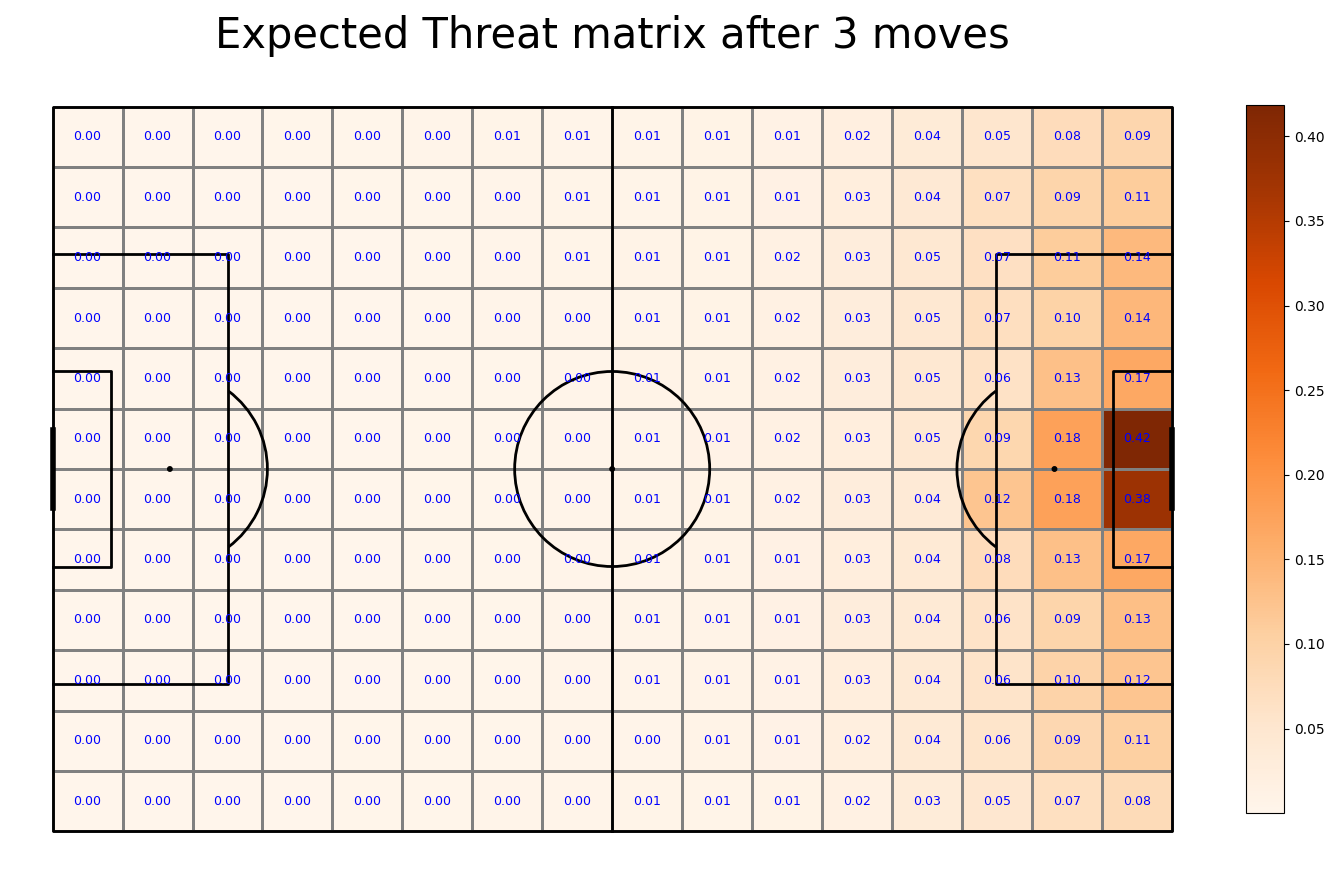

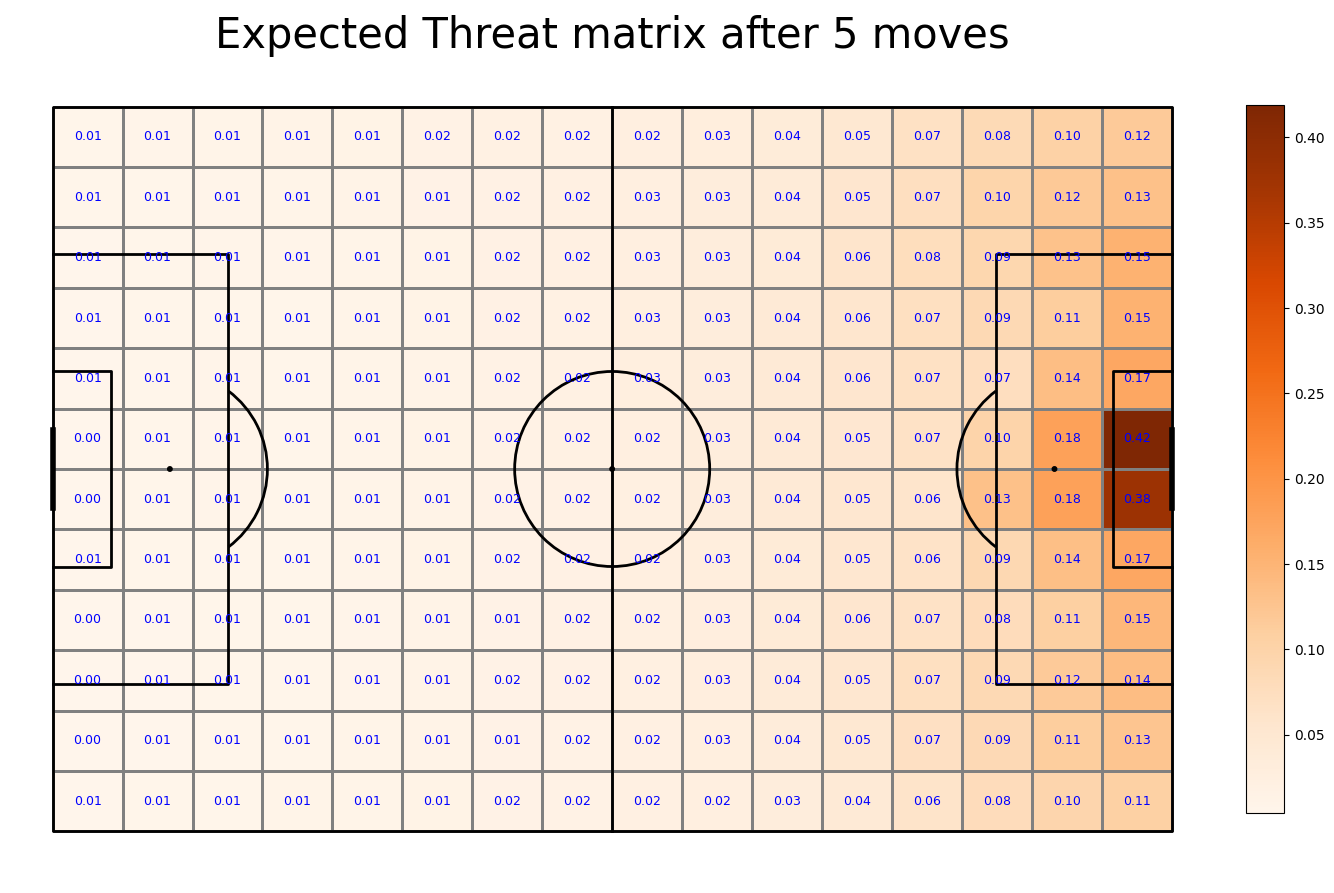

In [34]:
for i in range(6): # set iteration depth
    shoot_expected_payoff = goal_probability*shot_probability # matrix multiplication
    move_expected_payoff = move_probability*(np.sum(np.sum(transition_matrices_array*xT, axis = 2), axis = 1).reshape(16,12).T)
    xT = shoot_expected_payoff + move_expected_payoff

    if i%2 == 0:
        # plot iteration to show convergence
        fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                         endnote_height=0.01, title_space=0, endnote_space=0)
        goal["statistic"] = xT # assign xT to statistic 
        pcm  = pitch.heatmap(goal, cmap='Oranges', edgecolor='grey', ax=ax['pitch'])
        labels = pitch.label_heatmap(goal, color='blue', fontsize=9,
                                 ax=ax['pitch'], ha='center', va='center', str_format="{0:,.2f}", zorder = 3)
        # legend to our plot
        ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
        cbar = plt.colorbar(pcm, cax=ax_cbar)
        txt = 'Expected Threat matrix after ' +  str(i+1) + ' moves'
        fig.suptitle(txt, fontsize = 30)
        plt.show()

### Applying xT value to moving actions
As the next step, Calculate the xT added for progressive and successful events. 

> From the xT matrix, get the xT value for starting and ending zone and subtract the start from the finish. This is one appraoch to determining xT contributed by the action. 

An alternative would be to keep all moving the ball actions, calculate added xT for successful ones, and assign negative xT value of the starting zone for unsuccessful actions.

### Considered refactoring below code
After struggling to vectorize the pandas code below, eventually the effort to find a solution was taking longer than the computation to run the code as is, and hence the decision to leave intermediate states and add columns using the apply() one by one methodology.

In [35]:
# first look at the vectorize function.  Did not scale well
val_0 = np.vectorize(lambda val:val[0]-1)
val_1 = np.vectorize(lambda val:val[1]-1)
df = pd.DataFrame({'col1': [(1, 2), (3, 4), (5, 6)]})
(val_0(df.col1)),(val_1(df.col1))

(array([0, 2, 4]), array([1, 3, 5]))

In [36]:
# only successful actions filter
successful_moves = move_df.loc[lambda df_:df_.apply(lambda x:{'id':1801} in x.tags, axis = 1)]

In [37]:
# calculatexT using sector changes
successful_moves["xT_added"] = successful_moves.apply(lambda row: xT[row.end_sector[1] - 1][row.end_sector[0] - 1]
                                                      - xT[row.start_sector[1] - 1][row.start_sector[0] - 1], 
                                                      axis = 1)

In [38]:
# only progressive (i.e. positive impact)
value_adding_actions = successful_moves.loc[successful_moves["xT_added"] > 0]

In [39]:
value_adding_actions.sample(3)

,index,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,...,id,nextEvent,kickedOut,x,y,end_x,end_y,start_sector,end_sector,xT_added
9276,19802,8,Simple pass,[{'id': 1801}],339789,"[{'y': 42, 'x': 37}, {'y': 49, 'x': 47}]",2499731,Pass,1613,1H,...,183186064,Simple pass,0,38.85,39.44,49.35,34.68,"(6, 7)","(8, 7)",0.007732
167026,346010,8,Simple pass,[{'id': 1801}],703,"[{'y': 43, 'x': 23}, {'y': 23, 'x': 22}]",2499924,Pass,1619,1H,...,218199897,Simple pass,0,24.15,38.76,23.10,52.36,"(4, 7)","(4, 10)",0.000090
163148,337700,8,Simple pass,[{'id': 1801}],7919,"[{'y': 66, 'x': 22}, {'y': 37, 'x': 26}]",2499919,Pass,1623,1H,...,218248185,Simple pass,0,23.10,23.12,27.30,42.84,"(4, 5)","(5, 8)",0.002704


## Finding out players with highest xT
To find which players who played more than 400 minutes scored the best in possesion-adjusted xT per 90 repeat steps that from the Radar Plots process. 
1. Group them by player, sum
2. Assign and merge it with players database to keep player names 
3. Adjust by team possesion and per 90 min play. The last step differs, since we stored percentage_df in a .json file that can be found [here](https://github.com/soccermatics/Soccermatics/tree/main/course/lessons/minutes_played).

In [40]:
# group by player
xT_by_player = value_adding_actions.groupby(["playerId"])["xT_added"].sum().reset_index()

In [41]:
xT_by_player.head(3) # no name in the basic information

,playerId,xT_added
0,36,9.344838
1,38,2.165398
2,48,19.726985


In [42]:
# path for player name information
path = os.path.join(str(pathlib.Path().resolve().parents[0]),'footy_analytics','data','players.json')

In [43]:
player_df = (pd.read_json(path, encoding='unicode-escape')
             .rename(columns = {'wyId':'playerId'})
             .assign(role = lambda df_: df_.role.apply(lambda nest: nest['name']))
            )

In [44]:
summary = xT_by_player.merge(player_df[['playerId', 'shortName', 'role']], how = "left", on = ["playerId"])
summary.head(3)

,playerId,xT_added,shortName,role
0,36,9.344838,T. Alderweireld,Defender
1,38,2.165398,D. Blind,Defender
2,48,19.726985,J. Vertonghen,Defender


In [45]:
# pull in minutes played per player
path = os.path.join(str(pathlib.Path().resolve().parents[0]),'footy_analytics', 'minutes_played_per_game_England.json')
with open(path) as f:
    minutes_per_game = json.load(f)
#filtering over 400 per game
minutes = (pd.DataFrame(minutes_per_game)
                    .groupby(["playerId"]).minutesPlayed.sum()
                    .reset_index()
                   )
minutes.head(3)

,playerId,minutesPlayed
0,36,1238
1,38,382
2,48,3343


In [46]:
summary = (minutes
           .merge(summary, how = "left", on = ["playerId"])
           .fillna(0)
           .loc[lambda df_:df_["minutesPlayed"] > 400] # must be greater than 400min
           .assign(xT_per_90 = lambda df_: df_.xT_added*90/df_.minutesPlayed) #calculating per 90
          )
summary.head(3)
# summary = summary
# summary = summary.loc[summary["minutesPlayed"] > 400]

,playerId,minutesPlayed,xT_added,shortName,role,xT_per_90
0,36,1238,9.344838,T. Alderweireld,Defender,0.679350
2,48,3343,19.726985,J. Vertonghen,Defender,0.531088
3,54,3348,22.605678,C. Eriksen,Midfielder,0.607680


In [47]:
#adjusting for possesion
path = os.path.join(str(pathlib.Path().resolve().parents[0]),"footy_analytics", 'player_possesion_England.json')
with open(path) as f:
    percentage_df = json.load(f)
percentage_df = pd.DataFrame(percentage_df)
percentage_df.head(3)

,playerId,possesion
0,9206,0.446999
1,9127,0.439018
2,93,0.438288


In [48]:
# merge it
summary = (summary
 .merge(percentage_df, how = "left", on = ["playerId"])
 .assign(xT_adjusted_per_90 = lambda df_:(df_.xT_added/df_.possesion)*90/df_["minutesPlayed"])
)

In [49]:
(summary
 [['shortName', 'xT_adjusted_per_90']]
 .sort_values(by='xT_adjusted_per_90', ascending=False)
 .head(10)
)

,shortName,xT_adjusted_per_90
27,Fàbregas,1.765339
68,P. Pogba,1.381286
271,K. De Bruyne,1.359145
78,J. Shelvey,1.351588
22,M. Özil,1.329378
77,J. Henderson,1.280351
39,Philippe Coutinho,1.260505
118,J. Milner,1.256543
117,David Silva,1.227768
76,C. Adam,1.216886


### Challenge
1. Write the Calculating Expected Threat matrix section using for loops to get a better understanding of the algorithm! -- This seems to be how it was created in the base case...
2. Don’t remove unsuccessful and non-progressive actions. Assign -xT for unsuccessful ones!

In [50]:
# Add xT column
# (move_df
#  .assign(xT = lambda df_: df_.apply(lambda row: xT[row.end_sector[1] - 1][row.end_sector[0] - 1] 
#                                     - xT[row.start_sector[1] - 1][row.start_sector[0] - 1], 
#                                                       axis = 1))
#  .assign(success = lambda df_: df_.apply(lambda x:{'id':1801} in x.tags, axis = 1),
#          xT_fin = lambda df_: np.where(df_.success==False, -0.02, df_.xT))
# )

## Action Based xT (Expected Threat)
All of the work up to this point was based on position based expected threat.  It essentially valued the pass based on the new position created, and the likelihood of a shot and subsequent likelihood of a goal if the shot is taken.  This provides a good indicator of the value of a given pass, but penalizes (or undervalues) a switch of the ball.  It is clear that a simple position based approach is oversimplified.

Moving to possession chaings and leveraging action based expected threat determination will provide additional understanding to the actions which led up to a chance.  With the complexity of chains also comes increased ability to approach the problem in different ways.  In particular, design decisions around what constitutes a possession chain, and when it is broken must be determined, or what types of actions should be devalued (hopeful cross, clearance to the corner, etc.   

### Possession Chains
The first step is to break the games down into possession chains.  This will account for the starting and ending position of an action on the pitch.  Ball out restarts will break chains, as will a loss of the ball to the opposition (two consecutive touches).  

In [51]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [60]:
#load data - store it in train dataframe
df = pd.DataFrame()
with open('./data/events_England.json') as f:
    data = json.load(f)
    df = pd.DataFrame(data).reset_index().drop('index', axis=1)

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 643150 entries, 0 to 643149
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   eventId       643150 non-null  int64  
 1   subEventName  643150 non-null  object 
 2   tags          643150 non-null  object 
 3   playerId      643150 non-null  int64  
 4   positions     643150 non-null  object 
 5   matchId       643150 non-null  int64  
 6   eventName     643150 non-null  object 
 7   teamId        643150 non-null  int64  
 8   matchPeriod   643150 non-null  object 
 9   eventSec      643150 non-null  float64
 10  subEventId    643150 non-null  object 
 11  id            643150 non-null  int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 58.9+ MB


### Prepare the data
To create possession chains requires knowledge of the next event in the event data.  To extract this data a shifted value must be determined for the possession. Beyong the next action shift, a number of event types are used to filter the data to obtain possession chains. 
1. Create a new column with the next event. This is taken from a shifted dataframe of the event data.
2. Create a column with 1 if the ball was kicked out - to mark when the chain should be stopped. This will filter out Interruptions since there was a ball out of the pitch or foul prior to the interuption. 
3. Filter lost duels, since Wyscout duels are saved twice - for both teams either defensive or offensive. 
4. Filter out events “Out of bounds” since this information is available from the other column. 
5. Filter out events by goalkeepers, since shots were made before.

In [62]:
next_event = df.shift(-1, fill_value=0)

In [63]:
# intermediate value for filtering
lost_duels = (df
              .loc[df["eventName"] == "Duel"]
              .loc[lambda df_: df_.apply(lambda x:{'id':1802} in x.tags, axis = 1)]
             )
lost_duels.shape

(68476, 12)

In [67]:
# trying to match prep.  Cannot get same rows
df = (df
 .assign(nextEvent = next_event.subEventName,
         kickedOut = lambda df_: np.where(df_.nextEvent == "Ball out of the field",1,0))
 .drop(lost_duels.index)
 .query("eventName != 'Interruption'")
 .query("subEventName != 'Ball out of field'")
 .query("~subEventName.isin(['Goalkeeper leaving line','Save attempt', 'Reflexes'])") 
)

In [58]:
# df["nextEvent"] = next_event["subEventName"]
# df["kickedOut"] = df.apply(lambda x: 1 if x.nextEvent == "Ball out of the field" else 0, axis = 1)
# # interruptions out
# interruption = df.loc[df["eventName"] == "Interruption"]
# # filter out non-accurate duels - in wyscout they are 2 way - attacking and defending
# lost_duels = df.loc[df["eventName"] == "Duel"]
# lost_duels = lost_duels.loc[lost_duels.apply (lambda x:{'id':1802} in x.tags, axis = 1)]
# df = df.drop(lost_duels.index)
# # filter ball out of the field - I can get this anyways
# out_of_ball = df.loc[df["subEventName"] == "Ball out of the field"]
# df = df.drop(out_of_ball.index)
# # save attempts can be dropped
# goalies = df.loc[df["subEventName"].isin(["Goalkeeper leaving line", "Save attempt", "Reflexes"])]
# df = df.drop(goalies.index)

### Isolating possesion chain
Then isolate possesion chains based on the rules 
1. If the ball was touched once by the opposing team, the chain is not broken. 
2. If there is a foul or the ball kicked out of the field the chain is stopped. 
3. When the opposing team is on the ball, when it is properly intercepted that is, the next team is the one that made the next event, stop the chain. 
4. Otherwise, if the ball was only touched, but did not change possesion, we treat a pass as an accurate one. 

Note that this is an approximation of a true possesion chain. In the industry datasets come with possesion chains already isolated.

In [ ]:
# functional programming
def isolateChains(df):
    """
    Parameters
    ----------
    df : dataframe
        dataframe with Wyscout event data.

    Returns
    -------
    df: dataframe
        dataframe with isolated possesion chains

    """

In [ ]:
df = isolateChains(df)
#investigate a chain
df.loc[df["possesion_chain"] == 4][["eventName", "possesion_chain"]]